# Clustering Warmup

In [1]:
###############################################################################
### python imports                                                          ###
###############################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")

# from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
###############################################################################
### local imports                                                           ###
###############################################################################

from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain
from acquire import check_df
from clusterfunctions import compare_ks, set_kmeans_clusters, plot_2d_clusters

1. Get the [csv file from here][1].

    This dataset is 50,000 posts from [the relationships subreddit](https://www.reddit.com/r/relationships/). The posts in this subreddit follow a specific format, the poster very often includes their age and their partner's age. Posts without ages for both partners, and posts without a male and female partner are excluded. The female age and male age have been extracted into the first two columns. The third column is the post's unique id, and the fourth is the text of the post.

[1]: https://drive.google.com/file/d/1xdB-XfBi67MaCh_8h_a34iH3-I1KJS62/view

In [3]:
local_settings.debug=True

In [4]:
rdf = check_df(pd.read_csv('50k_posts_from_relationship_advice.csv',header=None, names=['age_f','age_m','id','post_text']), splain=True)

2019-11-06 09:58:00 starting check_df
2019-11-06 09:58:00 starting frame_splain
DATAFRAME SHAPE:
(47540, 4) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47540 entries, 0 to 47539
Data columns (total 4 columns):
age_f        47540 non-null int64
age_m        47540 non-null int64
id           47540 non-null object
post_text    47540 non-null object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB
None 

DATAFRAME DESCRIPTION:
         count       mean        std  min   25%   50%   75%     max
age_f  47540.0  23.050715  23.436143  0.0  19.0  22.0  25.0  5000.0
age_m  47540.0  24.269605   6.315841  5.0  20.0  23.0  27.0   420.0 

DATAFRAME HEAD:
   age_f  age_m      id                                          post_text
0     24     25  3iwivb  I'm [25/M] having issues with my GF [24/F] Fac...
1     18     20  3iwrcd  I [20M] asked a friend [18F] to the movies. Di...
2     17     16  3iwucq  Me (16/M) not sure if co-worker (17/F) is bein...
3     17     16  3iwx0l  M

In [5]:
rdf['age_diff'] = rdf.age_m - rdf.age_f

In [6]:
rdf['age_mean'] = ((rdf.age_m + rdf.age_f) / 2)

In [7]:
rdf['age_score'] = rdf.age_diff / rdf.age_mean

In [8]:
rdf['abs_score'] = abs(rdf.age_score)

In [9]:
frame_splain(rdf, splain=True, debug=True)

2019-11-06 09:58:00 starting frame_splain
DATAFRAME SHAPE:
(47540, 8) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47540 entries, 0 to 47539
Data columns (total 8 columns):
age_f        47540 non-null int64
age_m        47540 non-null int64
id           47540 non-null object
post_text    47540 non-null object
age_diff     47540 non-null int64
age_mean     47540 non-null float64
age_score    47540 non-null float64
abs_score    47540 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 2.9+ MB
None 

DATAFRAME DESCRIPTION:
             count       mean        std         min   25%        50%  \
age_f      47540.0  23.050715  23.436143     0.00000  19.0  22.000000   
age_m      47540.0  24.269605   6.315841     5.00000  20.0  23.000000   
age_diff   47540.0   1.218889  23.308503 -4979.00000   0.0   1.000000   
age_mean   47540.0  23.660160  12.599593    10.00000  20.0  23.000000   
age_score  47540.0   0.051535   0.140767    -1.98327   0.0   0.0425

*Find and remove silly age ranges*

In [10]:
rdf[abs(rdf.age_diff)>=50].sort_values(by='age_diff', ascending=False).head(10)

,age_f,age_m,id,post_text,age_diff,age_mean,age_score,abs_score
43042,69,420,bxop8q,Me (F/69) failing to sustain relationship with...,351,244.5,1.435583,1.435583
42649,21,223,bwxygc,I [21F] fucked up a big project bf [223M] has ...,202,122.0,1.655738,1.655738
22425,29,93,4uxrl5,My [29F] grandpa [93M] just got placed on comf...,64,61.0,1.049180,1.049180
15357,19,81,4eibe1,My [19F] almost deaf grandpa [81M] is a terrib...,62,50.0,1.240000,1.240000
44484,20,70,bzsbuk,Should we love our true and beloved creator [7...,50,45.0,1.111111,1.111111
40955,77,18,buieqz,My (M/18) grandmother (F/77) is currently in a...,-59,47.5,-1.242105,1.242105
40931,98,30,buhmj6,I (30M) am not sure my GF (98F) sees a future ...,-68,64.0,-1.062500,1.062500
9988,176,19,42l8sk,Her [176f] lies bother me [19m],-157,97.5,-1.610256,1.610256
15981,5000,21,4fsg3a,"Me(21M), thinks my partner (5000F), shows a lo...",-4979,2510.5,-1.983270,1.983270


In [11]:
rdf = rdf[abs(rdf.age_diff)<=50]

In [12]:
rdf[(rdf.age_m<13) | (rdf.age_f<13)]

,age_f,age_m,id,post_text,age_diff,age_mean,age_score,abs_score
1905,3,42,3mo7ma,I (M42) got scared today in children museum be...,39,22.5,1.733333,1.733333
3997,12,19,3qta0c,Need help with my little sister [12F] and her ...,7,15.5,0.451613,0.451613
9563,12,19,41nfow,I (12/F) am in LOVE with this famous youtuber ...,7,15.5,0.451613,0.451613
14053,5,22,4bzycd,I'm [22/m] not being allowed to see my daughte...,17,13.5,1.259259,1.259259
14054,5,22,4c02q3,I'm [22/m] not being allowed to see my daughte...,17,13.5,1.259259,1.259259
15057,20,6,4e018i,My [20F] parents [44 - 45 MF] are trying to ge...,-14,13.0,-1.076923,1.076923
15296,9,19,4eeij7,My [19/m] sister [9/f] might not pass the 3rd ...,10,14.0,0.714286,0.714286
17227,23,7,4iq9jx,The boy (7m) I (23f) nanny almost got me fired,-16,15.0,-1.066667,1.066667
19542,12,16,4ny14w,"I, (16/m), have the most irrational sister (12...",4,14.0,0.285714,0.285714
21543,10,20,4syqky,I [20/M] work at a daycare for troubled kids f...,10,15.0,0.666667,0.666667


In [13]:
rdf = rdf[(rdf.age_m>=13) & (rdf.age_f>=13)]

In [14]:
frame_splain(rdf, splain=True)

2019-11-06 09:58:00 starting frame_splain
DATAFRAME SHAPE:
(47486, 8) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47486 entries, 0 to 47539
Data columns (total 8 columns):
age_f        47486 non-null int64
age_m        47486 non-null int64
id           47486 non-null object
post_text    47486 non-null object
age_diff     47486 non-null int64
age_mean     47486 non-null float64
age_score    47486 non-null float64
abs_score    47486 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 3.3+ MB
None 

DATAFRAME DESCRIPTION:
             count       mean       std        min   25%        50%  \
age_f      47486.0  22.947374  5.229479  13.000000  19.0  22.000000   
age_m      47486.0  24.260077  5.955767  13.000000  20.0  23.000000   
age_diff   47486.0   1.312703  4.112613 -47.000000   0.0   1.000000   
age_mean   47486.0  23.603725  5.213531  13.000000  20.0  23.000000   
age_score  47486.0   0.051391  0.135904  -1.164179   0.0   0.042553   
abs_sc

2. Perform k-means clustering on the combination of male and female age. Add the predicted cluster as another column on the dataframe.

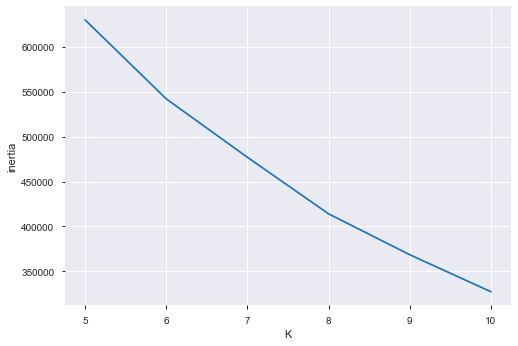

In [15]:
rdf_fama = rdf[['age_f', 'age_m']]
compare_ks(rdf_fama, min_k=5, max_k=10)

In [16]:
rdf_fama = set_kmeans_clusters(rdf_fama, n_clusters=8)

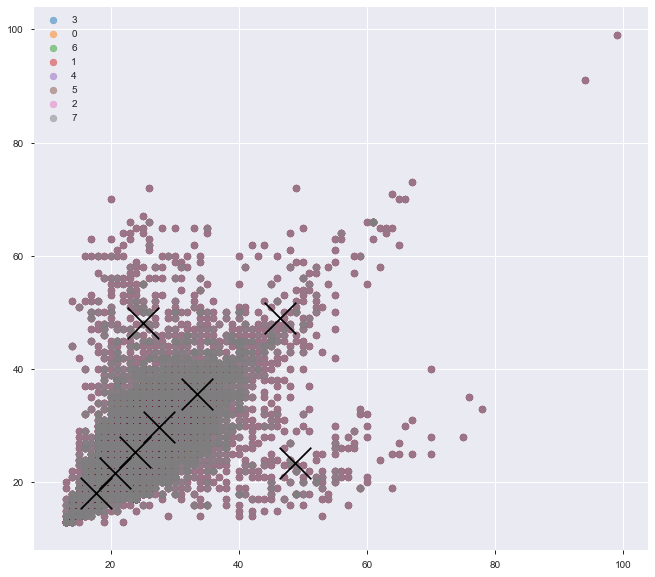

In [17]:
%matplotlib inline

plt.figure(figsize=(11,10))
plot_2d_clusters(rdf_fama, 'age_f', 'age_m', 'cluster', alpha=.5)


3. Visualize your clustering results. What do you notice? What could you change to fix this?

4. Play with the data! What sort of visualizations can you make, what kind of insights can you come up with?